# Law, Order, and Algorithms
## Analyzing "stop-and-frisk" policy

In [3]:
# Load packages
library(tidyverse)
library(glue)
library(ROCR)

theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




## Background

"Stop-and-frisk" is a police practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband.

In New York City, between 2003 and 2013, over 100,000 stops were made per year, with 685,724 people being stopped at the height of the program in 2011. The vast majority of those stopped were African-American or Latino, raising concerns of racial bias. You can read more about this [here](https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City).

In this section, we will work with a sample of stops in NYC made between 2007-2013, recorded on a [UF-250 form](https://www.prisonlegalnews.org/news/publications/blank-uf-250-form-stop-question-and-frisk-report-worksheet-nypd-2016/) to explore whether we are able to produce a better, statistically driven frisk policy.

In [4]:
# Load data
stops <- read_rds(file = "../data/sqf_sample.rds")

# Preprocess the data
cols_to_keep <- c('found_weapon', 'frisked', 'suspected_crime',
                  'precinct',
                  'suspect_race', 'suspect_sex', 'suspect_build',
                  'month', 'day',
                  'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 'stopped_bc_drugs', 'stopped_bc_violent', 
                  'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 'stopped_bc_desc',
                  'inside_outside', 'location_housing',
                  'additional_highcrime', 'additional_investigation', 'additional_proximity', 'additional_direction', 'additional_other',
                  'additional_associating', 'additional_sights', 'additional_time', 'additional_evasive', 'additional_report',
                  'radio_run', 'officer_uniform',
                  'suspect_height', 'suspect_weight', 'observation_period', 'suspect_age', 'local_hit_rate', 'year')
stops <- stops %>%
  select(any_of(cols_to_keep)) %>%
  # only keep stops with information in all entries
  na.omit() %>%
  mutate(
    # convert non-numerical variables into factors, grouping values occurring < 0.1% of the time into "Other"
    across(where(is.character) | where(is.logical) | where(is.factor), 
           ~ fct_lump(factor(.x), prop = 0.001)),
    # convert outcome into numeric
    across(all_of('found_weapon'), ~ if_else(.x == "TRUE", 1, 0)),
    frisked = as.logical(frisked),
    suspect_race = if_else(suspect_race == "white", "white", str_to_title(suspect_race))
  )

head(stops)

found_weapon,frisked,suspected_crime,precinct,suspect_race,suspect_sex,suspect_build,month,day,stopped_bc_furtive,⋯,additional_evasive,additional_report,radio_run,officer_uniform,suspect_height,suspect_weight,observation_period,suspect_age,local_hit_rate,year
<dbl>,<lgl>,<fct>,<fct>,<chr>,<fct>,<fct>,<ord>,<ord>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
0,TRUE,cpw,113,Black,male,medium,January,Thursday,TRUE,⋯,FALSE,FALSE,FALSE,FALSE,5.833333,180,1,30,0.02293595,2011
0,FALSE,criminal possession of marihuana,23,Hispanic,male,medium,August,Friday,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,5.666667,170,2,28,0.09288934,2011
0,FALSE,criminal possession of marihuana,107,Hispanic,male,medium,May,Tuesday,TRUE,⋯,TRUE,FALSE,FALSE,TRUE,5.833333,140,2,17,0.07364701,2011
0,TRUE,cpw,44,Black,male,thin,June,Thursday,TRUE,⋯,FALSE,TRUE,FALSE,TRUE,5.500000,155,1,23,0.01776445,2012
0,TRUE,cpw,115,Hispanic,male,thin,March,Tuesday,FALSE,⋯,TRUE,FALSE,TRUE,TRUE,5.500000,170,2,19,0.02217064,2009
0,TRUE,cpw,23,Hispanic,male,thin,November,Sunday,FALSE,⋯,TRUE,FALSE,FALSE,TRUE,5.500000,165,1,15,0.04430036,2009


## The data

This week, we will use the same data frame as last week: `stops`, a sample of stops in NYC, recorded on a 
[UF-250 form][uf250_link].
As a reminder, below is a list of columns in the data, roughly corresponding to the [UF-250 form][uf250_link]:

* Base information regarding stop:
    * `id`, `serial`, `year`, `date`, `day`, `time`, `hour`, `precinct`, `location_housing`, 
      `suspected_crime`, `lat`, `lon`, `xcoord`, `ycoord`

* Circumstances which led to the stop:
    * `stopped_bc_object`, `stopped_bc_desc`, `stopped_bc_casing`, `stopped_bc_lookout`, `stopped_bc_clothing`, `stopped_bc_drugs`, `stopped_bc_furtive`, `stopped_bc_violent`, `stopped_bc_bulge`, `stopped_bc_other`
    
* Suspect demographics:
    * `suspect_dob`, `suspect_id_type`, `suspect_sex`, `suspect_race`,
      `suspect_hispanic`, `suspect_age`, `suspect_height`, `suspect_weight`,
      `suspect_hair`, `suspect_eye`, `suspect_build`, `reason_explained`,
      `others_stopped`

* Whether physical force was used:
    * `force_hands`, `force_wall`, `force_ground`, `force_drawn`,
      `force_pointed`, `force_baton`, `force_handcuffs`,
      `force_pepper`, `force_other`

* Was suspect arrested?: `arrested`
    * if yes: `arrested_reason`

* Was summons issued?: `summons_issued`

* Officer in uniform?: `officer_uniform`, `officer_verbal`, `officer_shield`

* Was person frisked?: `frisked`
    * if yes: `frisked_bc_suspected_crime`, `frisked_bc_weapons`, `frisked_bc_attire`, `frisked_bc_actual_crime`, `frisked_bc_noncompliance`, `frisked_bc_threats`, `frisked_bc_prior`, `frisked_bc_furtive`, `frisked_bc_bulge`

* Was person searched?: `searched`,
    * if yes: `searched_hardobject`, `searched_outline`,
      `searched_admission`, `searched_other`

* Was weapon found?: `found_weapon`
    * if yes: `found_gun`, `found_pistol`, `found_rifle`, `found_assault`,
      `found_knife`, `found_machinegun`, `found_other`
      
* Was other contraband found?: `found_contraband`

* Additional circumstances/factors
    * `additional_report`, `additional_investigation`, `additional_proximity`, 
      `additional_evasive`, `additional_associating`, `additional_direction`, 
      `additional_highcrime`, `additional_time`, `additional_sights`, 
      `additional_other`

* Additional reports prepared: `extra_reports`

* Whether the stop was a resultof a radio run: `radio_run`

* Was the stop made inside or outside: `inside_outside`

* Period of observation (minutes): `observation_period`, `stop_length`

* Type of ID the person had (photo, refused, verified, other): `identification`

* Local hit rate: `local_hit_rate`, defined as the average hit rate for drug and cpw stops at the location of the stop for the previous year, using gaussian kernel averaging. NA if it's other type of stops.

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf
      

## Analysis

For this lab, we will focus on stops for suspicion of criminal possession of a weapon (CPW), as only legal reason for an officer to conduct a frisk is for officer safety.

#### Exercise: Data filtering

In [5]:
# Your code here!
# Create a data frame named stops_cpw with only cpw stops as indicated by column suspected_crime
# START solution

stops_cpw <- stops %>%
  filter(suspected_crime == "cpw")

# END solution

As the only justified goal of a frisk is to recover weapons under reasonable suspicion,
given this data, can we create a statistically driven frisk policy by building a risk assessment model?
Such a policy can often be constructed in the following two steps:

1. Fit a statistical model to estimate _risk_
1. Set a threshold at which the decision is made.

For the example of deciding whether or not to frisk individuals who have 
been stopped, the _risk_ is the probability that a weapon is recovered
if we were to frisk the individual.
We would like to frisk only the individuals that are most likely to carry a weapon.
Then the policy would be to frisk individuals whose estimated probability of
carrying a weapon is greater than some pre-selected value that we consider optimal.

<!-- [TODO: we want to frisk the highest likely people to have, we frisk those whose probabilit is  > cost ] -->

We will take a closer look at each of these steps below.


### Estimating risk

The only legal reason for an officer to conduct a frisk is for officer
safety. In other words, the only justified goal of a frisk is to recover
weapons.
For an individual $i$, let $X_i$ be all the information we know about the
individual prior to making the frisk decision, and define


$$
Y_i =
\begin{cases}
1 & \textrm{if weapon is found on individual } i \\
0 & \textrm{otherwise}
\end{cases}
$$


Then, the _risk_ we are interested in measuring can be written as

$$
r_i = \Pr(Y_i = 1 ~|~ X_i)
$$



In other words, we wish to estimate the probability that we will recover a 
weapon from an individual, characterized by covariates $X_i$, if we were to 
frisk them.

One way to estimate this probability is to fit a logistic regression on the
subset of individuals who were frisked, to predict whether a weapon will be
found, using all the covariates that an officer observed prior to conducting the
frisk. 

We then split the data into two parts: training set and test set.
We train our logistic regression model using the training set and evaluate it on the test set, so that when evaluting the model, we won't get falsely good performance.
You can read more about this at [this page](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).

In [6]:
# Split train-test set
stops_train_cpw <- stops_cpw %>%
  filter(year %in% 2009:2010)

stops_test_cpw <- stops_cpw %>%
  filter(year %in% 2011:2012)

We train and make predictions with the logistic regression model as follows:

In [7]:
# Specifying the model
features <- c('precinct', 'suspect_race')

# We will use all covariates listed in `features` to predict the outcome "found_weapon" 
glm_formula <- reformulate(features, response="found_weapon")

# Train model
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial(link = "logit"))

# Make predictions on the test set
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

There are many ways to evaluate the logistic regression model's performance.
For binary classification task like the one we are working on (predicting whether or not someone carries a weapon), a common performance metric is [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).
A perfect binary prediction model will give an AUC of 1 while a model that is making random guess will produce an AUC of 0.5.

In [8]:
# Helper function to calculate AUC
compute_auc <- function(probs, labels) {
  pred <- prediction(probs, labels)
  auc <- performance(pred, 'auc')
  auc <- unlist(slot(auc, 'y.values'))
  auc
}

compute_auc(probs = predictions, labels = stops_test_cpw$found_weapon)

[1] 0.6940509

Now let's see if we can achieve a higher AUC by incluiding more covariates in the logistic regression model.

#### Exercise: Building a better logistic regression model

In [9]:
# Your code here!
# Build a better logistic regression model here by including more covariates
# START solution

binary_features <- c('precinct',
                     'suspect_race', 'suspect_sex', 'suspect_build',
                     'month', 'day',
                     'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 'stopped_bc_drugs', 'stopped_bc_violent', 
                     'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 'stopped_bc_desc',
                     'inside_outside', 'location_housing',
                     'additional_highcrime', 'additional_investigation', 'additional_proximity', 'additional_direction', 'additional_other',
                     'additional_associating', 'additional_sights', 'additional_time', 'additional_evasive', 'additional_report',
                     'radio_run', 'officer_uniform')
realvalued_features <- c('suspect_height', 'suspect_weight', 'observation_period', 'suspect_age', 'local_hit_rate', 'year')
features <- c(binary_features, realvalued_features)

glm_formula <- reformulate(features, response="found_weapon")
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial(link = "logit"))
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

# END solution

# check the AUC of the new model
compute_auc(probs = predictions, labels = stops_test_cpw$found_weapon)

[1] 0.8193921

Assuming our model provides good, calibrated estimates of weapon carrying probabilities,
one way to learn about the risk distribution is to check its [cumulative distirbution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function).
Given a threshold p, the CDF $F(x=p)$ is defined as the proportion of stops with smaller than p ex-ante (predicted) chance of recovering a weapon.

#### Exercise: Calculate CDF value given a weapon recovery probability threshold 

In [10]:
# Add our predictions to the data frame
stops_test_cpw <- stops_test_cpw %>%
  mutate(found_weapon_pred = predictions)

# Given a threshold p between 0 and 1 (e.g., 0.01)
p <- 0.01
# Calculate the proportion of stops with smaller than p ex-ante chance of recovering a weapon

# Your code here!
# START solution
stops_test_cpw %>% 
  summarize(prop_stops = mean(found_weapon_pred < p))
# END solution

prop_stops
<dbl>
0.311557


When we trace over the CDF values for all possible proability thresholds p, we are able to obtain a curve of weapon recovery probability vs CDF values.

#### Exercise: Calculate weapon recovery probability and corresdponing CDF

In [31]:
# Your code here!
# create a data frame named weapon_recovery_vs_cdf with 2 columns: p and cdf
# representing all possible thresholds and the corresponding cdf values.
# START solution

weapon_recovery_vs_cdf <- stops_test_cpw %>%
  arrange(found_weapon_pred) %>%
  mutate(p = found_weapon_pred,
         cdf = 1:n() / n())

# or alternatively
weapon_recovery_vs_cdf <- map_dfr(seq(0, 1, 0.001),
                                  ~tibble(
                                      p = .x,
                                      cdf = mean(stops_test_cpw$found_weapon_pred < p)
                                  ))

# END solution

#### Exercise: Overall hit rate
Let's also calculate the overall hit rate for the test set.
As a reminder, hit rate is defined as the percent of cases in which a weapon is found among stops for suspicion of criminal possession of a weapon (CPW).

In [32]:
# Your code here!
# Calculate overall hit rate
# the output should be a single number stored in variable hit_rate_overall
# START solution
hit_rate_overall <- mean(stops_test_cpw$found_weapon)
# END solution

We can plot weapon recovery probabilities against CDF values, with a dashed line in the plot showing the overall hit rate in the dataset.

Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


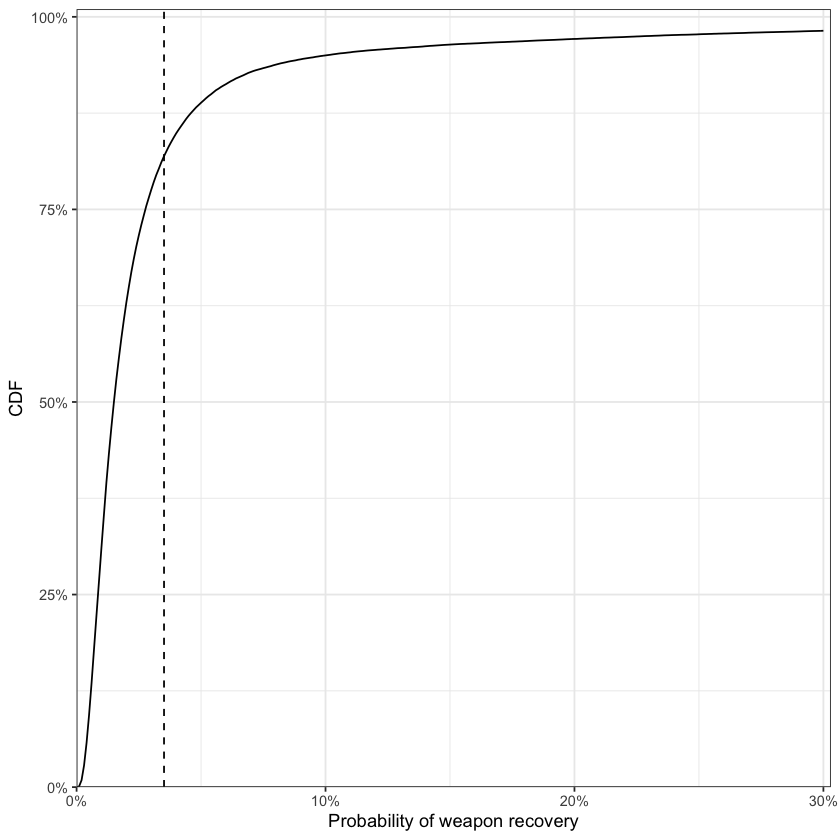

In [33]:
ggplot(weapon_recovery_vs_cdf, aes(x = p, y = cdf)) +
  geom_vline(xintercept=hit_rate_overall, linetype='dashed') +
  geom_line() +
  scale_x_continuous('Probability of weapon recovery', labels = scales::percent,
                     limits = c(0, 0.3), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('CDF', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) 

Now let's re-compute the CDF values and the hit rates for Black, Hispanic, and white individuals.

#### Exercise: Calculate weapon recovery probability and corresdponing CDF by race

In [34]:
# Your code here!
# Calculate threshold vs. cdf by race for Black, Hispanic, and white individuals
# The output should be a data frame named weapon_recovery_vs_cdf_by_race containing 3 columns: suspect_race, p, and cdf
# START solution
weapon_recovery_vs_cdf_by_race <- stops_test_cpw %>%
  filter(suspect_race %in% c("Black", "Hispanic", "white")) %>%
  arrange(found_weapon_pred) %>%
  group_by(suspect_race) %>%
  mutate(p = found_weapon_pred,
         cdf = 1:n() / n()) %>%
  select(suspect_race, p, cdf)
# END solution

#### Exercise: Hit rate by race

In [35]:
# Your code here!
# Calculate hit rate by race for Black, Hispanic, and white individuals
# The output should be a data frame named hit_rate_by_race with 2 columns: suspect_race and hit_rate
# START solution
hit_rate_by_race <- stops_test_cpw %>%
  filter(suspect_race %in% c("Black", "Hispanic", "white")) %>%
  group_by(suspect_race) %>%
  summarize(hit_rate = mean(found_weapon))
# END solution

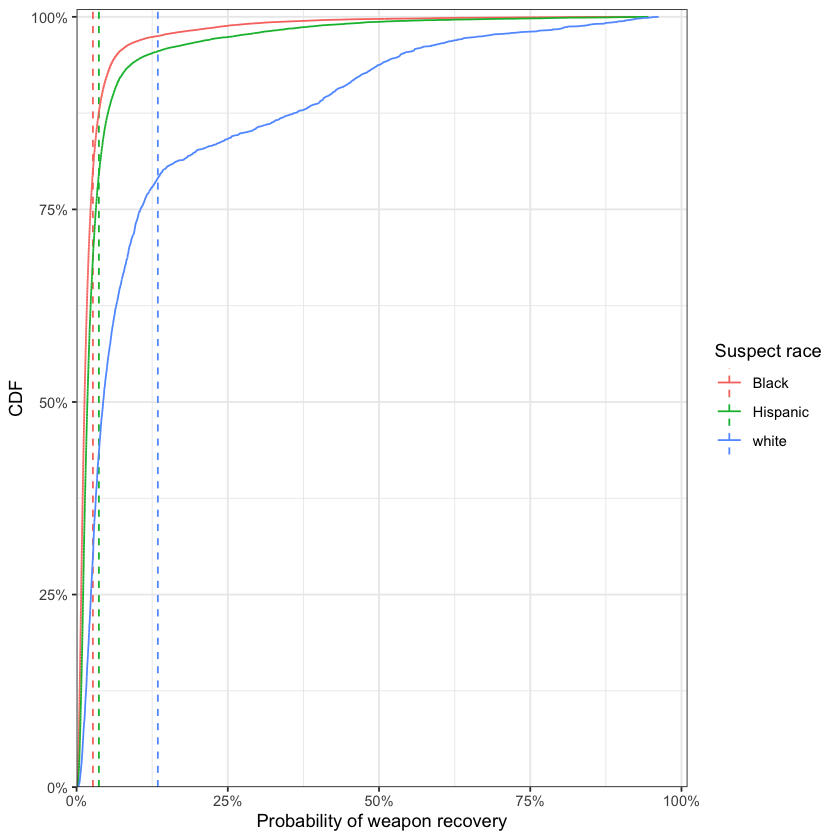

In [36]:
# weapon recovery probability vs. CDF
ggplot(weapon_recovery_vs_cdf_by_race, aes(x = p, y = cdf, color = suspect_race)) +
  geom_vline(data=hit_rate_by_race, aes(xintercept=hit_rate, color = suspect_race), linetype='dashed') +
  geom_line() +
  scale_x_continuous('Probability of weapon recovery', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('CDF', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_color_discrete("Suspect race")


\[Discuss: What do we see in the plot?\]

### Devising an alternative statistically driven frisk policy

Given risk estimates, we can now propose a policy by setting a threshold on the predicted probability of finding a weapon. Finding an optimal threshold, however, will depend largely on the various cost/benefits associated with a frisk.

One thing to consider when determining an optimal threshold, for example, might be the proportion of weapons that are recovered, as a function of how many people are frisked.

From a technical point-of-view, we can compute and plot this trade-off by first sorting our data frame in decreasing order of the estimated risk. Then, compute a running tally of the proportion of stopped individuals who are frisked (i.e., higher risk individuals are frisked first), as well as the proportion of weapons that are recovered. A running tally, or cumulative sum, can be computed using the cumsum function.

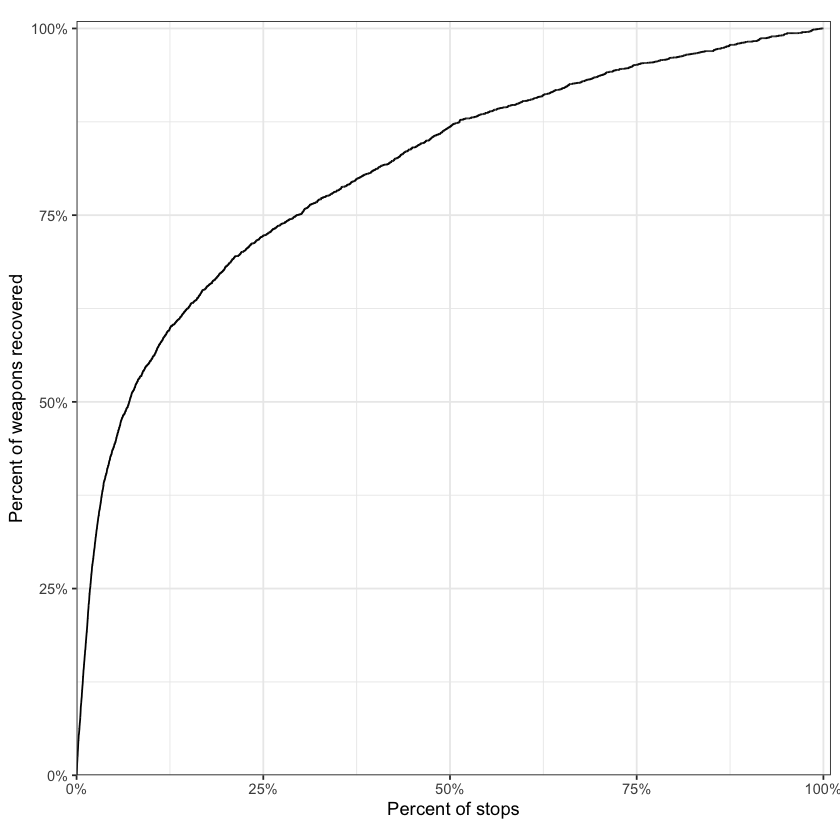

In [17]:
# Percent weapons recovered by percent of stops
stops_vs_weapons_recovered <- stops_test_cpw %>%
  arrange(desc(found_weapon_pred)) %>%
  mutate(percent_outcome = cumsum(found_weapon)/sum(found_weapon),
         stops = 1:n() / n()) %>%
  select(stops, percent_outcome, found_weapon_pred)

tradeoff_plot <- ggplot(stops_vs_weapons_recovered, aes(x = stops, y = percent_outcome)) +
  geom_line() +
  scale_x_continuous('Percent of stops', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('Percent of weapons recovered', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  coord_equal()
tradeoff_plot

Given this trade-off, we can now find the optimal policy based on various
cost/benefit constraints.
For example, if we were to require that at least 80% of all weapons must be recovered, 
while frisking as few people as possible, we could find the threshold to be the
lowest value of risk where we recover at least 80% of all weapons.

stops,percent_outcome,found_weapon_pred
<dbl>,<dbl>,<dbl>
0.3781517,0.8000706,0.01967251


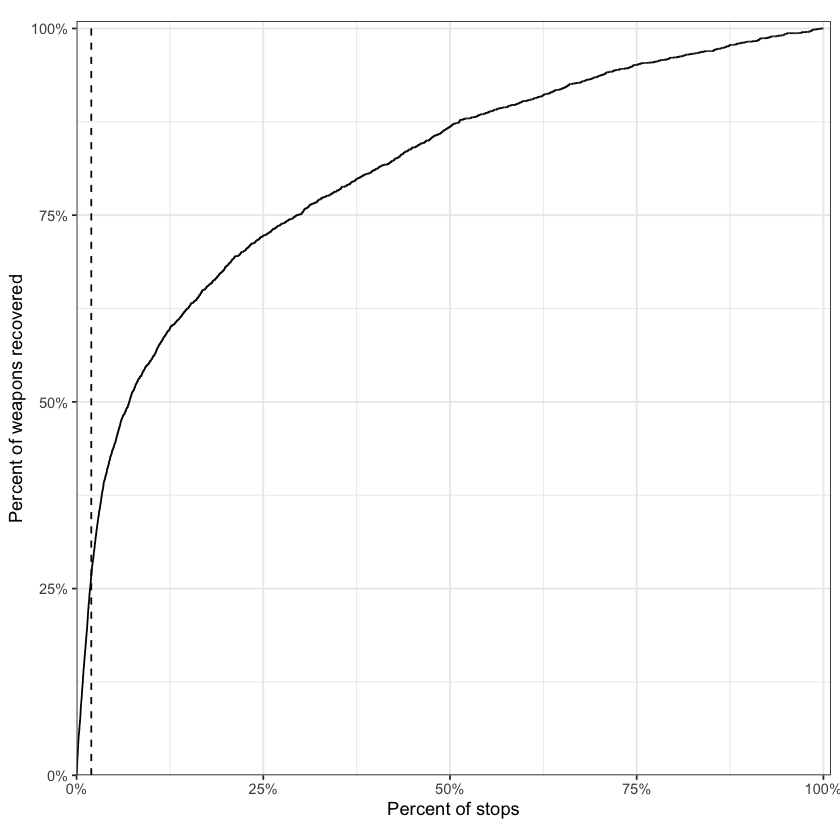

In [23]:
threshold <- stops_vs_weapons_recovered %>% 
  filter(percent_outcome >= .8) %>% 
  arrange(desc(found_weapon_pred)) %>% 
  slice(1) 

threshold

tradeoff_plot +
  geom_vline(xintercept = threshold$found_weapon_pred,
             linetype = "dashed")

We can see that this is acheived by setting a threshold of

In [24]:
scales::percent(threshold$found_weapon_pred)

49438 
 "2%"

i.e., only frisk an individual if the predicted probability of recovering a weapon is greater than that.
And if we were to implement this policy, we expect about

In [25]:
scales::percent(threshold$stops)

[1] "38%"

of stopped individuals to be frisked as a result, compared to the original frisk rate among cpw stops:

In [26]:
scales::percent(mean(stops_cpw$frisked))

[1] "88%"